In [2]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

> https://www.kaggle.com/competitions/mercari-price-suggestion-challenge/data

> 데이터의 속성
- train_id : 데이터 id
- name : 제품명 
- item_condition_id : 판매자가 제공하는 제품 상태
- category_name : 카테고리 명
- brand_name : 브랜드 이름
- shipping: 배송비 무료 여부, 1이면 무료/0이면 유료
- item_description : 제품에 대한 설명

- price : 제품가격 (예측을 위한 타겟속성)

**회귀로 피처를 학습한 뒤 price를 예측하는 문제. 기존 회귀 문제와 다른점은 item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행한다는 점**

## 데이터 전처리 

In [3]:
mercari_df = pd.read_csv("mercari_train.tsv", sep="\t")

In [3]:
print(mercari_df.shape)

(1482535, 8)


In [4]:
mercari_df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [5]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name은 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터가 Null로 되어있음
- category_name은 약 6300건 null 데이터
- item_descripition의 null 값은 4건으로 미비 / 하지만 별도 설명이 없는 경우 "No description yet"으로 되어 있음

-> 이 null 데이터는 이후에 적절한 문자열로 치환


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: xlabel='price', ylabel='Count'>

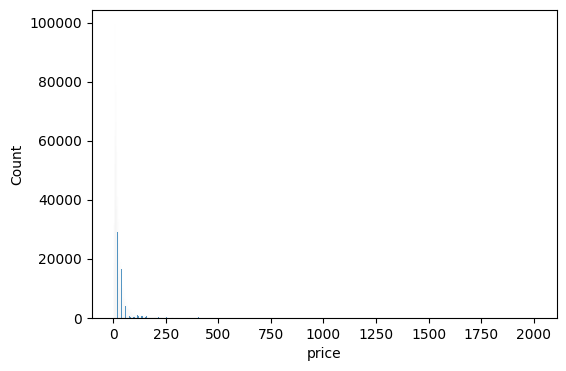

In [7]:
y_train_df = mercari_df["price"]
plt.figure(figsize=(6,4))
sns.histplot(y_train_df)

In [7]:
import numpy as np

<Axes: xlabel='price', ylabel='Count'>

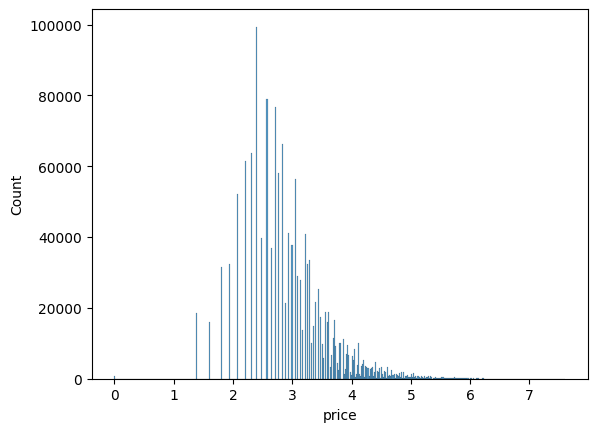

In [9]:
y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df)

- price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포돼 있습니다. Price 칼럼을 로그 값으로 변환한 뒤 분포도를 다시 보면 비교적 정규 분포에 가까운 데이터를 이루게 됩니다. 

In [8]:
mercari_df["price"] = np.log1p(mercari_df["price"])

In [11]:
mercari_df["price"].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [12]:
print("Shipping 값 유형:\n", mercari_df["shipping"].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64


In [13]:
print("item_condition_id 값 유형:\n", mercari_df["item_condition_id"].value_counts())

item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


In [14]:
boolen_cond = mercari_df["item_description"] =="No description yet"

mercari_df[boolen_cond]["item_description"].count()

82489

먼저 category_name이 Null이 아닌 경우에 split("/")을 이용해 대, 중, 소 분류를 분리 <br>
만일 category_name이 Null일 경우에는 split() 함수가 error를 발생하므로 이 error를 except catch하여 대, 중, 소 분류 모두 "Other Null"값을 분류

대, 중, 소 칼럼은 mercari_df에서 cat_dae, cat_jung, cat_so로 부여 <br>
**고민해야할 점**<br>
판다스의 apply lambda로 반환되는 데이터 세트가 리스트를 요소로 가지고 있는데, 이를 다시 DataFrame 칼럼으로 분리해야 함. 이 부분은 다음 코드에서처럼 zip과 *를 apply lambda 식에 적용하면 여러 개의 칼럼으로 간단하게 분리할 수 있음

In [9]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성 -> 대, 중, 소 값을 리스트로 반환

def split_cat(category_name):
    try:
        return category_name.split("/")
    except:
        return ["Other_Null","Other_Null","Other_Null"]


In [10]:
#위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성

mercari_df["cat_dae"], mercari_df["cat_jung"], mercari_df["cat_so"] = \
                                               zip(*mercari_df["category_name"].apply(lambda x: split_cat(x)))


In [12]:
print("대분류 유형: \n", mercari_df["cat_dae"].value_counts())
print("중분류 유형: \n", mercari_df["cat_jung"].nunique())
print("소분류 유형: \n", mercari_df["cat_so"].nunique())

대분류 유형: 
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 유형: 
 114
소분류 유형: 
 871


In [11]:
mercari_df["brand_name"] = mercari_df["brand_name"].fillna(value="Other_Null")
mercari_df["category_name"] = mercari_df["category_name"].fillna(value="Other_Null")
mercari_df["item_description"] = mercari_df["item_description"].fillna(value="Other_Null")

In [13]:
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

## 피처 인코딩과 피처 벡터화 

Mercari Price Suggestion에 이용되는 데이터 세트는 문자열 칼럼이 많습니다. 
이 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별해 보겠습니다 

Mercari Price Suggestion에서 예측 모델은 price 값, 즉 상품 가격을 예측해야 하므로 회귀 모델을 기반으로 함. 
- 선형 회귀 모델과 회귀 트리 모델을 모두 적용할 예정이며, 특히 선형회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 (라벨 인코딩 대신) 원-핫 인코딩을 적용하겠습니다
- 피처 벡터화의 경우는 비교적 짧은 텍스트의 경우는 Count 기반의 벡터화를, 긴 텍스트는 TD-IDF 기반의 벡터화를 적용


### brand_name

In [20]:
print("brand name의 유형 건수: ", mercari_df["brand_name"].nunique())
print("brand name의 sample 5건: \n", mercari_df["brand_name"].value_counts()[:5])

brand name의 유형 건수:  4810
brand name의 sample 5건: 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


-> 대부분 명료한 문자열. 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용하면 됨. brand_name의 종류가 4810건으로 원-핫 인코딩으로 변환하기에 다소 많아 보이나 본 예제의 ML 모델 구축상 큰 문제는 없음 

### name

In [21]:
print("name의 종류 개수: ", mercari_df["name"].nunique())
print("name sample 10건 : \n", mercari_df["name"][:10])

name의 종류 개수:  1225273
name sample 10건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


-> 종류가 매우 많음. 개별적으로 거의 고유한 상품명을 가지고 있음. <br>
-> Name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 돼 있으므로 Count 기반으로 피처 벡터화 변환을 적용하겠음

## category_name
-> 이전에 전처리를 통해서 해당 칼럼은 대, 중, 소 분류 세 개의 칼럼인 cat_dae, cat_jung, cat_so 칼럼으로 분류. 이들 칼럼도 원-핫 인코딩
## shipping, item_condition_id
-> 각각 두 가지 유형의 값 , 다섯 가지 유형의 값을 가지고 있음. 원-핫 인코딩 적용
## item_description
-> 상품에 대한 간단 설명으로 데이터에서 가장 긴 텍스트를 가지고 있음 ; TF-IDF

In [22]:
pd.set_option("max_colwidth", 200)

#item_description의 평균 문자열 크기
print("item_description 평균 문자열 크기:", mercari_df["item_description"].str.len().mean())

mercari_df["item_description"][:2]

item_description 평균 문자열 크기: 145.71139703278507


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

### 피처 벡터화 

In [14]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)


#item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words="english")
X_descp = tfidf_descp.fit_transform(mercari_df["item_description"])

print("name vectorization shape:", X_name.shape)
print("item_description vectorization shape:", X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


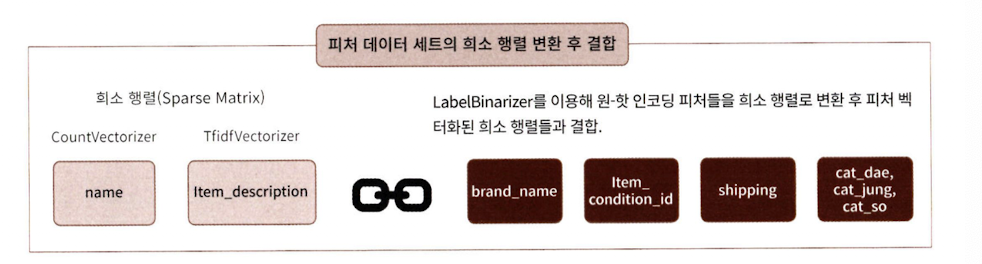

In [6]:
from IPython.display import Image
Image(filename='/Users/ijiseon/Desktop/피처인코딩.png')

> CountVectorizer, TfidVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태입니다. 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야 하고 앞으로 인코딩 될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descp와 결합해 ML 모델을 실행하는 기반 데이터 세트로 재구성돼야 함

> 이를 위해서 이 인코딩 대상 칼럼도 밀집 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합하도록 하겠습니다. 사이킷런은 원-핫 인코딩을 위해 OneHotEncoder와 LabelBinarizer 클래스를 제공합니다. 이 중 LabelBinarizer 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원합니다. 생성 시 sparse_out = True로 파라미터를 설정해주기만 하면 됩니다. 모든 인코딩 대상 칼럼은 LabelBinarizer를 이용해 희소 행렬 형태의 원-핫 인코딩으로 변환하겠습니다.

> 개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지 sparse모듈의 hstack()함수를 이용해 결합하겠습니다. hstack()함수는 희소 행렬을 손쉽게 칼럼 레벨로 결합할 수 있게 해줍니다. 


In [15]:
from sklearn.preprocessing import LabelBinarizer

In [16]:
# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환

lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df["brand_name"])

In [17]:
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df["item_condition_id"])

In [18]:
lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df["shipping"])

In [19]:
# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환

lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df["cat_dae"])

In [20]:
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df["cat_jung"])

In [21]:
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df["cat_so"])

In [22]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))

print("X_brand shape: {0}, X_item_cond_id shape: {1}".format(X_brand.shape, X_item_cond_id.shape))
print("X_shipping shape : {0}, X_cat_dae shape: {1}".format(X_shipping.shape, X_cat_dae.shape))
print("X_cat_jung shape: {0}, X_cat_so shape: {1}".format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape: (1482535, 4810), X_item_cond_id shape: (1482535, 5)
X_shipping shape : (1482535, 1), X_cat_dae shape: (1482535, 11)
X_cat_jung shape: (1482535, 114), X_cat_so shape: (1482535, 871)


> 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입입니다. 그리고 brand_name 칼럼 경우 값의 유형이 4810개이므로 이를 원-핫 인코딩으로 변환한 X_brand_shape의 경우 4810개의 인코딩 칼럼을 가지게 되었습니다. X_cat_so의 경우도 마찬가지로 871개의 인코딩 칼럼을 가집니다. 인코딩 칼럼이 매우 많이 생겼지만 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제될 것은 없습니다.

In [27]:
from scipy.sparse import hstack
import gc

In [33]:
sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

In [34]:
# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합

X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


#### 참고

여기서 사용된 hstack 메소드는 여러 희소 행렬(sparse matrices)을 수평으로 (즉, 열 방향으로) 결합하는 데 사용됩니다. 이를 통해 다양한 특성(feature)을 갖는 데이터를 하나의 통합된 특성 행렬로 결합할 수 있어, 머신 러닝 모델의 입력으로 사용하기에 적합하게 만들어 줍니다.

- 희소 행렬의 hstack 원리: <br>
희소 행렬(Sparse Matrix): 데이터의 대부분이 0인 행렬을 효율적으로 저장하기 위한 방식입니다. 메모리 사용을 최소화하면서 행렬 연산을 할 수 있도록 돕습니다.
- hstack 기능: <br>
scipy.sparse.hstack은 주어진 희소 행렬 리스트를 받아서 모든 행렬의 행이 일치하도록 열 방향으로 연결합니다.<br>
예를 들어, 두 행렬 A (m x n)와 B (m x p)를 hstack으로 결합하면, 결과 행렬은 C (m x (n+p)) 형태를 갖게 됩니다.

데이터 처리 예:<br>
예에서는 다양한 특성을 나타내는 여러 개의 희소 행렬이 있습니다 (name, item_description, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so). <br>
이 행렬들의 열의 합은 각각의 열 수를 더한 값과 같습니다:
name vectorization shape: 105757 열 /
item_description vectorization shape: 50000 열 /
X_brand shape: 4810 열 /
X_item_cond_id shape: 5 열 /
X_shipping shape: 1 열 /
X_cat_dae shape: 11 열 /
X_cat_jung shape: 114 열 /
X_cat_so shape: 871 열 <br>

이를 모두 합칠 때, 총 열의 수는 161569 열이 됩니다 (105757 + 50000 + 4810 + 5 + 1 + 11 + 114 + 871).
이렇게 결합된 하나의 큰 희소 행렬은 머신 러닝 모델에 다양한 특성을 동시에 제공할 수 있어 모델의 성능을 개선할 수 있습니다. 희소 행렬 형태로 데이터를 유지하면서도, 여러 데이터 소스의 정보를 통합할 수 있는 효율적인 방법입니다.







In [35]:
# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제

del X_features_sparse
gc.collect()

0

## 릿지 회귀 모델 구축 및 평가 

In [23]:
def rmsle(y, y_pred):
    #underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt( np.mean( np.power(np.log1p(y) - np.log1p(y_pred), 2) ) )

In [24]:
def evaluate_org_price(y_test, preds):
    #원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    #rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [28]:
def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소행렬 결합
    X = hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df["price"],
                                                       test_size=0.2, random_state=156)
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

In [29]:
linear_model = Ridge(solver="lsqr", fit_intercept=False)

In [30]:
sparse_matrix_list = (X_name, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)

print("Item Description을 제외했을 때 rmsle 값:", evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4984207984133985


In [31]:
sparse_matrix_list = ( X_descp, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)

print("Item Description을 포함했을 때 rmsle 값:", evaluate_org_price(y_test, linear_preds))

Item Description을 포함했을 때 rmsle 값: 0.5109198270709732


## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [32]:
from lightgbm import LGBMRegressor

In [ ]:
sparse_matrix_list = ( X_descp, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print("LightGBM rmsle 값:", evaluate_org_price(y_test, lgbm_preds))

In [ ]:
preds = lgbm_preds*0.45 + linear_preds*0.55

print("LightGBM과 Ridge를 ensemble한 최종 rmsle 값:", evaluate_org_predict(y_test,preds))